# stochastic gradient descent (SGD)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp
import sklearn.model_selection 
import pandas as pd

In [2]:

def sigmoid(x): 
    return 1/(1+np.exp(-x))

def f(w, x): 
    return sigmoid(x.T@w)

def MSE(y, y1): 
    res=np.sum(np.linalg.norm((y-y1))**2, axis=0)
    res/=y1.shape[0]
    return res

def l(w,D): 
    X,Y=D
    return (MSE(f(w,X), Y))

def grad_l(w, D):
    Mx, My=D
    d, N=Mx.shape
    res=Mx@(sigmoid(Mx.T@w)*(1-sigmoid(Mx.T@w))*(f(w,Mx)-My))
    return res
    
def normalize(X):
    return (X - X.min()) / (X.max() - X.min())

def SGD(l, grad_l, w0, D, batch_size, n_epochs, a): 
    X, Y= D
    d,N=X.shape
    n_batch_per_epoch=int(N/batch_size)

    f_val=np.zeros((n_epochs,))
    x_val=np.zeros((n_epochs,d))
    grads=np.zeros((n_epochs,))
    err=np.zeros((n_epochs, ))
    w=w0
    batchInd=np.zeros(batch_size)
    shuffledInd=np.arange(N)

    for epoch in range(n_epochs):
        np.random.shuffle(shuffledInd)
        print(f"epoch {epoch}/{n_epochs}", end='\r')

        for k in range (n_batch_per_epoch):
            batchInd=shuffledInd[batch_size*k : batch_size*(k+1)]
            Mx=X[:,batchInd]
            My=Y[batchInd]
            M=(Mx, My)

            w=w0-a/N*grad_l(w0,M)
            w0=w         

        f_val[epoch]=l(w, M)
        #x_val[epoch]=w
        #grads[epoch]=grad_l(w,M)
        err[epoch]=np.linalg.norm(grad_l(w,M), 2)
    print()        
    return f_val, w, grads, err

In [3]:
Data=pd.read_csv("../2/data.csv")
Data=np.array(Data)

In [4]:
digits=[1,3]

In [5]:
X=Data[:,1:]
Y=Data[:,0]

i1= (Y==digits[0])
i3= (Y==digits[1])
X=X[i1+i3,:]
Y=Y[i1+i3]
N,d=X.shape
Y=Y.reshape((N, 1))
N,d=X.shape
X_train, X_test, y_train, y_test= sklearn.model_selection.train_test_split(X, Y, test_size=0.33, random_state=np.random.randint(0,100))

y_train[y_train==digits[0]]=0
y_train[y_train==digits[1]]=1
y_test[y_test==digits[0]]=0
y_test[y_test==digits[1]]=1
X=X.T
X_train=X_train.T
X_test=X_test.T
print(f"shape of Xtrain: {X_train.shape}")
print(f"shape of Ytrain: {y_train.shape}")

w0=np.random.normal(0,1e-3,(d+1,1))
X_train_hat=np.concatenate((X_train, np.ones((1, X_train.shape[1]))), axis=0)
D=(normalize(X_train_hat), y_train)
n_epoch=50
f_val, w, grads, err=SGD(l, grad_l, w0, D, batch_size=30, n_epochs=n_epoch, a=1e-2)
 

shape of Xtrain: (784, 6053)
shape of Ytrain: (6053, 1)
epoch 49/50


Text(0, 0.5, 'error')

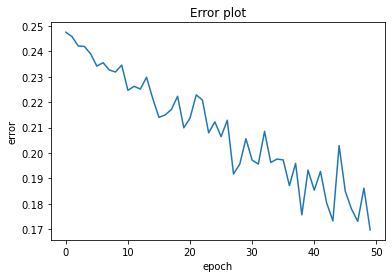

In [6]:
plt.plot(np.arange(n_epoch),f_val)
plt.title("Error plot")
plt.xlabel("epoch")
plt.ylabel("error")

Accuracy of test and train set

In [7]:
X_test_hat=np.concatenate((X_test, np.ones((1, X_test.shape[1]))), axis=0)

def predict(w, X, threshold=0.5):
    d,N=X.shape
    predictions=np.zeros((N,))
    result=f(w,X)
    for i in range(N):
        if(result[i]>threshold):
            predictions[i]=1
        else:
            predictions[i]=0
    return predictions

def accuracy(w, X, Y):
    N=X.shape[1]
    accuracy=0
    predictions=predict(w, X)
    for i in range(N):
        if(predictions[i]==Y[i]):
            accuracy+=1
    print(f"    accuracy: {accuracy/N}")
    print(f"    matches: {accuracy}")
    print(f"    total: {N}")
print("TRAIN ACCURACY")
accuracy(w, normalize(X_train_hat), y_train)
print()
print("TEST ACCURACY")
accuracy(w, X_test_hat, y_test)

TRAIN ACCURACY
    accuracy: 0.9755493143895589
    matches: 5905
    total: 6053

TEST ACCURACY
    accuracy: 0.9711602951039571
    matches: 2896
    total: 2982


# Comparison with GD
<hr>

In [8]:
def backtracking_vander(f, grad_f, x,A, b, l=1):
    alpha = 1
    c = 0.8
    tau = 0.25

    while f(x - alpha * grad_f(x,(A,b)), (A, b)) > f(x, (A, b)) - c * alpha * np.linalg.norm(grad_f(x,(A,b))) ** 2:
        alpha = tau * alpha

        if alpha < 1e-3:
            break
    return alpha
def GD_vander(f, grad_f, x0, tolf, tolx, kmax, A, b, l=0):
    a=1 
    f_val=np.zeros((kmax,))
    err_val=np.zeros((kmax,))
    x_val=[]
    x_val.append(x0)
    k=0
    conditions=True

    while (conditions):
        if(k!=0):
            a=backtracking_vander(f, grad_f, x, A, b, l)

        x=x0-a/N*grad_f(x0, (A, b))
        err_val[k]=np.linalg.norm(grad_f(x, (A, b)),2)
        x_val.append(x)

        k+=1
        stopcond1=np.linalg.norm(grad_f(x, (A, b))) > tolf*np.linalg.norm(grad_f(x_val[0], (A, b))) 
        stopcond2=np.linalg.norm(x-x0) > tolx*np.linalg.norm(x_val[0])
        conditions=k<kmax-1 and stopcond1 and stopcond2
        x0=x

    f_val=f_val[:k]
    err_val=err_val[:k]
    return x_val, f_val, err_val

In [9]:
w, f_val, err=GD_vander(l, grad_l, w0, 1e-6, 1e-6, 100, normalize(X_train_hat), y_train)

/var/folders/fv/ydry5cns22s8nv39vx30kvxh0000gn/T/ipykernel_49909/996693035.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Text(0, 0.5, 'error')

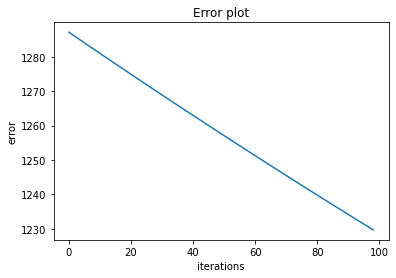

In [10]:
plt.plot(np.arange(len(err)),err)
plt.title("Error plot")
plt.xlabel("iterations")
plt.ylabel("error")

Accuracy of test and train sets

In [11]:
print("TRAIN ACCURACY")
accuracy(w[-1], X_train_hat, y_train)
print()
print("TEST ACCURACY")
accuracy(w[-1], X_test_hat, y_test)


TRAIN ACCURACY
    accuracy: 0.9620023129026929
    matches: 5823
    total: 6053

TEST ACCURACY
    accuracy: 0.9564050972501676
    matches: 2852
    total: 2982
